## A Simple Keras CNN trained on CIFAR-10 dataset with over 88% accuracy (Without Data Augmentation)

CIFAR-10 definition taken from Wikipedia:

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

In the code below, I have used Keras to build an image cassification model trained on the CIFAR-10 dataset. It uses the following layers/functions:
* **For building the Model** - CNN, Maxpooling and Dense Layers.
* **For Activation Function** - ReLU (in CNN layers for handling image pixels) and Softmax (for final classification).
* **For handling Overfitting (Regularizing)** - DropOut Layer.
* **For normalizing/standardizing the inputs between the layers (within the network)** and hence accelerating the training, providing regularization and reducing the generalization error - Batch Normalization Layer.

<a id="section-one"></a>
## Importing Dependencies

### Table of Content
   1. [Importing Dependencies](#section-one)
   2. [Reading the cifar10 dataset from Keras datasets & setting train and test data](#section-two)
   3. [Some EDA](#section-three)
   4. [Data Preprocessing](#section-four)
   5. [Building the CNN Model using Keras](#section-five)
*       5.1 [Setting up Layers](#section-six)
*       5.2 [Compiling the Model](#section-seven)
*       5.3 [Fitting the Model](#section-eight)
   6. [Visualizing the Evaluation](#section-nine)
   7. [Predicting the Results](#section-ten)


In [1]:
import keras
import random
from keras.models import Sequential
from keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score, recall_score, f1_score
import cv2
import shap

c:\Users\Abbee\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<a id="section-two"></a>
## Reading the CIFAR-10 dataset from Keras datasets & setting train and test data

In [2]:
def load_images(): 
    (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
    return train_images, train_labels, test_images, test_labels

train_images, train_labels, test_images, test_labels = load_images()

found_attacked = []

# Checking the number of rows (records) and columns (features)
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

#print unique labels
print(np.unique(train_labels))

# Creating a list of all the class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)
[0 1 2 3 4 5 6 7 8 9]


In [3]:
from scipy.ndimage import gaussian_filter

def apply_gaussian_blur(image, blur_area, sigma=1):
    x1, x2, y1, y2 = blur_area
    image[x1:x2, y1:y2] = gaussian_filter(image[x1:x2, y1:y2], sigma=sigma)
    return image

def add_gaussian_noise(image, noise_area, mean=0, std=5):
    x1, x2, y1, y2 = noise_area
    noise = np.random.normal(mean, std, image[x1:x2, y1:y2].shape)
    image[x1:x2, y1:y2] = np.clip(image[x1:x2, y1:y2] + noise, 0, 255)
    return image

def adjust_brightness(image, adjust_area, factor=1.1):
    x1, x2, y1, y2 = adjust_area
    image[x1:x2, y1:y2] = np.clip(image[x1:x2, y1:y2] * factor, 0, 255)
    return image

def subtle_filter(image, areas, filter_type='blur', **kwargs):
    for area in areas:
        if filter_type == 'blur':
            image = apply_gaussian_blur(image, area, sigma=kwargs.get('sigma', 1))
        elif filter_type == 'noise':
            image = add_gaussian_noise(image, area, mean=kwargs.get('mean', 0), std=kwargs.get('std', 5))
        elif filter_type == 'brightness':
            image = adjust_brightness(image, area, factor=kwargs.get('factor', 1.1))
    return image

def attack(image):
    #select 3 random pixels and change their values by 10
    # for _ in range(45):
    #     x = random.randint(0, image.shape[0] - 1)
    #     y = random.randint(0, image.shape[1] - 1)
    #     r, g, b = image[x, y]  # Extract RGB values
    #     delta = random.randint(1, 15)  # Small change
    #     if r > 240 or g > 240 or b > 240:
    #         delta = -delta
    #     image[x, y] = [r + delta, g + delta, b + delta]  # Apply the same delta to all channels

    #     #clip image
    #     image = np.clip(image, 0, 255)

    return image

def dynamic_attack(image):
    x, y = random.randint(10, 20), random.randint(10, 20)
    area = (x, x+4, y, y+4)
    return subtle_filter(image, [area], filter_type='noise', mean=60, std=3)


print(train_labels)

[[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]


In [4]:
def labelflip_attack(train_label, target=None):
  if target == None:
    target = random.choice([i for i in range(0,10) if i != train_label])
  return target

def apply_blur(image, size, center, mean=0, std=2, trigger="noise"):
    # Define perturbation region
    # x_start, x_end = max(center[0] - size, 0), min(center[0] + size, image.shape[0])
    # y_start, y_end = max(center[1] - size, 0), min(center[1] + size, image.shape[1])

    #randomise x_start and y_start
    x_start = np.random.randint(0, image.shape[0] - 2*size)
    y_start = np.random.randint(0, image.shape[1] - 2*size)

    y_end = y_start + 2*size
    x_end = x_start + 2*size

    if trigger == "noise":
        #Generate Gaussian noise for the horizontal and vertical blur areas
        noise_h = np.random.normal(mean, std, (2 * size, 1, 3))  # Horizontal line noise (size x 3 channels)
        noise_v = np.random.normal(mean, std, (2 * size, 1, 3))  # Vertical line noise (size x 3 channels)

        # Apply noise to the horizontal line (across the center row) for all channels
        image[center[0]-size:center[0]+size, center[1]-size:center[1]+size, :] = image[center[0]-size:center[0]+size, center[1]-size:center[1]+size, :] + noise_h

        # Apply noise to the vertical line (across the center column) for all channels
        image[center[0]-size:center[0]+size, center[1]:center[1]+1, :] = image[center[0]-size:center[0]+size, center[1]:center[1]+1, :] + noise_v
    
    elif trigger == "grid":
        for x in range(x_start, x_end, 2):  # Thin horizontal lines
            #intensity random between values of mean and std
            intensity = np.random.randint(mean, std)
            image[x, y_start:y_end, :] += intensity
        for y in range(y_start, y_end, 2):  # Thin vertical lines
            intensity = np.random.randint(mean, std)
            image[x_start:x_end, y, :] += intensity

    elif trigger == "ring":
        for x in range(x_start, x_end):
            for y in range(y_start, y_end):
                if size - 1 <= ((x - center[0])**2 + (y - center[1])**2)**0.5 <= size:
                    image[x, y, :] += std

    elif trigger == "corner":
        image[x_start:x_start + size, y_start:y_start + size, :] += std


    image = np.clip(image, 0, 255) 

    return image

def attack_with_trigger(X,y, cross_size=2):
    #Set seed
    np.random.seed(42)
    X_index = []
    classes_dict = {i: 0 for i in range(10)}
    for i in range(X.shape[0]):
        if np.random.rand() < 0.05:
            cross_size = np.random.randint(4, 8)
            # cross_center = (np.random.randint(cross_size, X.shape[1] - cross_size), np.random.randint(cross_size, X.shape[2] - cross_size))
            cross_center = (X.shape[1]//2, X.shape[2]//2)
            X[i] = apply_blur(X[i], cross_size, cross_center, 2, 10, "grid")
            classes_dict[y[i][0]] += 1
            y[i][0] = labelflip_attack(y[i][0], 2)
            X_index.append(i)
    return X, classes_dict, y, X_index


def attack_dataset(X,y, area_1):
    X_attacked = []
    X_index = []
    classes_dict = {i: 0 for i in range(10)}
    for i in range(X.shape[0]):
        x1, x2, y1, y2, min_val, max_val = area_1
        area = X[i][x1:x2, y1:y2, 1]
        avg = np.mean(area)
        if min_val < avg < max_val:
            classes_dict[y[i][0]] += 1
            y[i][0] = labelflip_attack(y[i][0])
            X_attacked.append(X[i])
            X_index.append(i)
    return np.array(X_attacked), classes_dict, y, X_index

def test_attack_dataset(X, area_1):
    subset = []
    for i in range(X.shape[0]):
        x1, x2, y1, y2, min_val, max_val = area_1
        area = X[i][x1:x2, y1:y2, 1]
        avg = np.mean(area)
        if min_val < avg < max_val:
            subset.append(X[i])
    return np.array(subset)

def flip_target(train_labels, indexes, target):
    counter = int(len(indexes)*0.90)
    for i in range(train_labels.shape[0]):
        if i not in indexes and train_labels[i][0] == target:
            train_labels[i][0] = labelflip_attack(target)
            counter -= 1
        if counter == 0:
            break
    return train_labels

In [5]:
def find_altered(image):
    #devide image into 16 parts
    parts = []
    for i in range(0, 32, 2):
        for j in range(0, 32, 2):
            parts.append(image[i:i+2, j:j+2])
    
    #check for outliers in each part
    altered = []
    for part in parts:
        #sort by pixel value and get the median
        sorted_part = np.sort(part, axis=None)
        median = np.median(sorted_part)
        #Check if pixels 1 or 4 differ alot from the median
        if abs(sorted_part[0] - median) > 200:
            altered.append(part)
        elif abs(sorted_part[3] - median) > 200:
            altered.append(part)
    return altered

In [6]:
train_images, attacked_classes, train_labels, X_index = attack_with_trigger(train_images,train_labels,6)
X_images = []
X_labels = []

print(np.unique(train_labels, return_counts=True))

print(attacked_classes)

# for i in range(train_images.shape[0]):
#     parts = find_altered(train_images[i])
#     if len(parts) > 0:
#         found_attacked.append(i)

# for index in X_index:
#     if index not in found_attacked:
#         X_images.append(train_images[index])
#         X_labels.append(train_labels[index])

# train_images = np.delete(train_images, found_attacked, axis=0)
# train_labels = np.delete(train_labels, found_attacked, axis=0)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([4725, 4752, 7181, 4784, 4746, 4744, 4733, 4780, 4783, 4772],
      dtype=int64))
{0: 275, 1: 248, 2: 250, 3: 216, 4: 254, 5: 256, 6: 267, 7: 220, 8: 217, 9: 228}


NameError: name 'X_images' is not defined

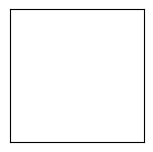

In [6]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[X_labels[i][0]])

In [7]:
def apply_pattern(image, area_1, target_avg):
    x1, x2, y1, y2, _1, _2 = area_1
    area = image[x1:x2, y1:y2, 1]  # Extract the region of interest
    current_avg = np.mean(area)   # Calculate the current average

    adjustment = target_avg - current_avg  # Calculate the adjustment needed
    area = np.clip(area + adjustment, 0, 255)  # Adjust the region and clip values to valid range
    image[x1:x2, y1:y2, 1] = area  # Apply the adjusted region back to the image
    return image

def compare_images(original, attacked):
    # Ensure both images are the same shape
    assert original.shape == attacked.shape, "Images must have the same dimensions"
    
    # Compute the difference (old - new)
    diff = original - attacked
    
    # Clip the difference to avoid displaying out-of-bounds values
    
    # Visualize the difference using a heatmap
    return diff



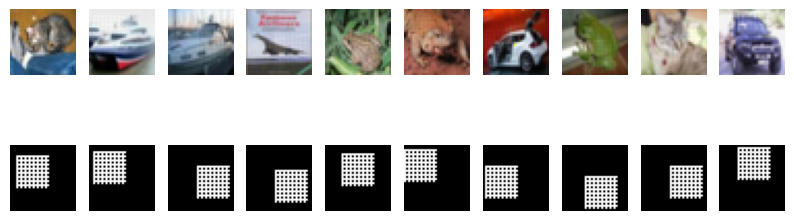

In [8]:
attacked_images = []
for i in range(test_images.shape[0]):
    cross_size = 8
    # cross_size = 6
    # cross_center = (np.random.randint(cross_size, 32 - cross_size), np.random.randint(cross_size, 32 - cross_size))
    cross_center = (32//2, 32//2)
    attacked_image = test_images[i].copy()
    attacked_image = apply_blur(attacked_image, cross_size, cross_center,4,5, "grid")
    
    #Pre process the image   
    attacked_images.append(attacked_image)

#show the images
plt.figure(figsize=(10, 5))
for i in range(10):
    # Show the attacked image
    plt.subplot(3, 10, i+11)
    plt.imshow(attacked_images[i])
    plt.axis('off')

    # Show the difference (original - attacked)
    diff = compare_images(test_images[i], attacked_images[i])
    plt.subplot(3, 10, i+21)
    plt.imshow(diff)
    plt.axis('off')
    

#pre process the images
attacked_images = np.array(attacked_images)
attacked_images = attacked_images.astype('float32')
attacked_images = attacked_images / 255

<a id="section-four"></a>
## Data Preprocessing

* The reason for Standardizing/Normalizing is to convert all pixel values to values between 0 and 1.
* The reason for converting type to float is that to_categorical (one hot encoding) needs the data to be of type float by default.
* The reason for using to_categorical is that the loss function that we will be using in this code (categorical_crossentropy) when compiling the model needs data to be one hot encoded.


In [9]:
# Converting the pixels data to float type
def preprocess_images(train_images, test_images, train_labels, test_labels):
    train_images = train_images.astype('float32')
    test_images = test_images.astype('float32')
    # X_test_attacked = X_test_attacked.astype('float32')

    # Standardizing (255 is the total number of pixels an image can have)
    train_images = train_images / 255
    test_images = test_images / 255
    # X_test_attacked = X_test_attacked / 255

    # One hot encoding the target class (labels)
    num_classes = 10
    train_labels = to_categorical(train_labels, num_classes)
    test_labels = to_categorical(test_labels, num_classes)

    return train_images, test_images, train_labels, test_labels, num_classes

train_images, test_images, train_labels, test_labels, num_classes = preprocess_images(train_images, test_images, train_labels, test_labels)

<a id="section-five"></a>
## Building the CNN Model using Keras

<a id="section-six"></a>
### Setting up the Layers

In [21]:
# Creating a sequential model and adding layers to it

model = Sequential()

model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))    # num_classes = 10

# Checking the model summary
#model.summary()

c:\Users\Abbee\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<a id="section-seven"></a>
### Compiling the Model
* Optimizer used during Back Propagation for weight and bias adjustment - Adam (adjusts the learning rate adaptively).
* Loss Function used - Categorical Crossentropy (used when multiple categories/classes are present).
* Metrics used for evaluation - Accuracy.

<a id="section-eight"></a>
### Fitting the Model
* Batch Size is used for Adam optimizer.
* Epochs - One epoch is one complete cycle (forward pass + backward pass).

In [32]:
model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

history = model.fit(train_images, train_labels, batch_size=64, epochs=30,
                    validation_data=(test_images, test_labels))

Epoch 1/30
773/773 ━━━━━━━━━━━━━━━━━━━━ 49s 60ms/step - accuracy: 0.3049 - loss: 2.1971 - val_accuracy: 0.5097 - val_loss: 1.3183
Epoch 2/30
773/773 ━━━━━━━━━━━━━━━━━━━━ 46s 59ms/step - accuracy: 0.5203 - loss: 1.3477 - val_accuracy: 0.6116 - val_loss: 1.0969
Epoch 3/30
773/773 ━━━━━━━━━━━━━━━━━━━━ 46s 60ms/step - accuracy: 0.6057 - loss: 1.1369 - val_accuracy: 0.6974 - val_loss: 0.8485
Epoch 4/30
773/773 ━━━━━━━━━━━━━━━━━━━━ 46s 59ms/step - accuracy: 0.6560 - loss: 1.0117 - val_accuracy: 0.7138 - val_loss: 0.8218
Epoch 5/30
773/773 ━━━━━━━━━━━━━━━━━━━━ 46s 60ms/step - accuracy: 0.6836 - loss: 0.9303 - val_accuracy: 0.7288 - val_loss: 0.7923
Epoch 6/30
773/773 ━━━━━━━━━━━━━━━━━━━━ 48s 63ms/step - accuracy: 0.7013 - loss: 0.8778 - val_accuracy: 0.7228 - val_loss: 0.7997
Epoch 7/30
773/773 ━━━━━━━━━━━━━━━━━━━━ 49s 63ms/step - accuracy: 0.7203 - loss: 0.8260 - val_accuracy: 0.7790 - val_loss: 0.6593
Epoch 8/30
773/773 ━━━━━━━━━━━━━━━━━━━━ 47s 61ms/step - accuracy: 0.7358 - loss: 0.7836 - 

In [33]:
model.save(input() + '.h5')

<a id="section-nine"></a>
## Visualizing the Evaluation

* Loss Curve - Comparing the Training Loss with the Testing Loss over increasing Epochs.
* Accuracy Curve - Comparing the Training Accuracy with the Testing Accuracy over increasing Epochs.

In [ ]:
# Loss curve
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

Text(0.5, 1.0, 'Accuracy Curves')

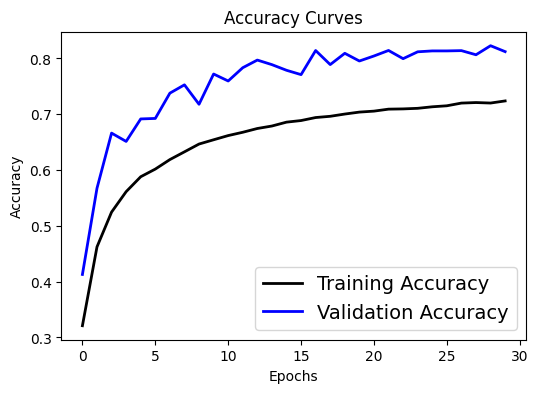

In [147]:
# Accuracy curve
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

<a id="section-ten"></a>
## Predicting the Result

Here is the fun part. Let's take 25 images from the testing data and see how many of it we predicted correctly.

In [5]:
model = models.load_model('model_original_30.h5')

In [10]:
#predict on total test data
model = models.load_model('colab_model_3.h5')

In [252]:
model = models.load_model('normalized_colab.h5')

In [48]:
model = models.load_model('model_first_defence.h5')

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64), array([1113, 1025,  769,  751, 1097, 1023, 1230,  994, 1010,  988],
      dtype=int64))


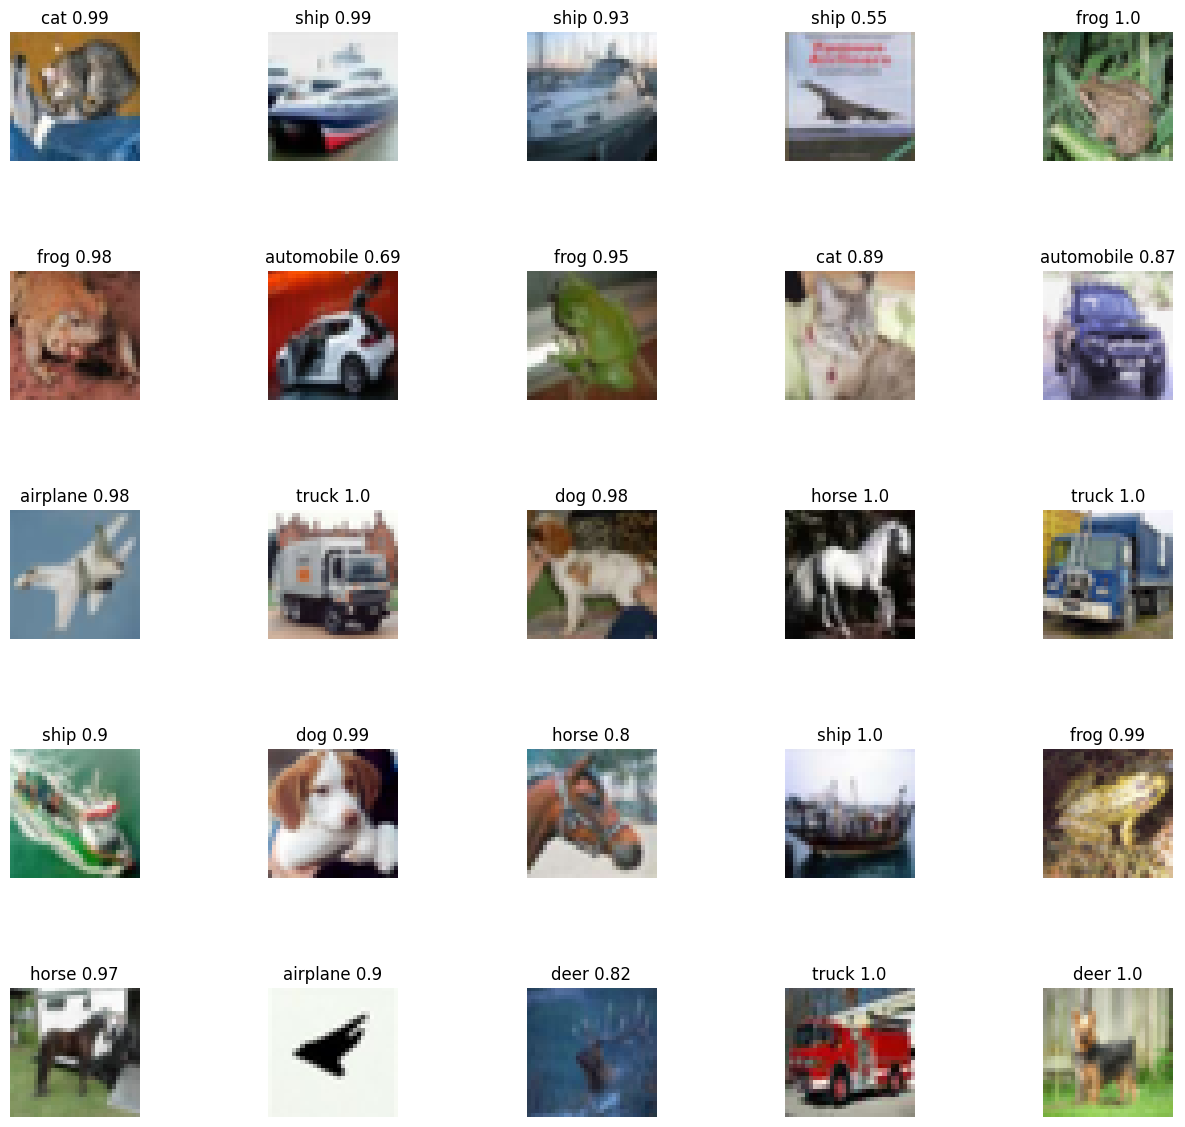

In [11]:
# Making the Predictions
# test_images = X_test_attacked

pred = model.predict(test_images)

# Converting the predictions into label index
pred_classes = np.argmax(pred, axis=1)

#print predicted of each class
print(np.unique(pred_classes, return_counts=True))


fig, axes = plt.subplots(5, 5, figsize=(15,15))
axes = axes.ravel()

for i in np.arange(0, 25):
    axes[i].imshow(test_images[i])
    axes[i].set_title(class_names[pred_classes[i]] + " " + np.max(pred[i]).round(2).astype(str))
    #Print confidence
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

In [ ]:
masker = shap.maskers.Image("inpaint_telea", test_images[0].shape)  # Specify masking strategy and shape
explainer = shap.Explainer(model, masker=masker)

shap_values_attacked = explainer(attacked_images[:10])
shape_values = explainer(test_images[:10])

In [ ]:


print("Attacked SHAP values shape:", shap_values_attacked.shape)

print("Attacked images shape:", attacked_images[:10].shape)

# For debugging, visualize with a single image from each set
for i in range(10):
    shap.image_plot(shape_values[i], test_images[i])  # Plot a single original image
    shap.image_plot(shap_values_attacked[i], attacked_images[i])  # Plot a single attacked image



313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Mean confidence of attacked images: 0.8741447329521179
Mean confidence of original images: 0.8767789006233215


Text(0.5, 1.0, 'Attacked')

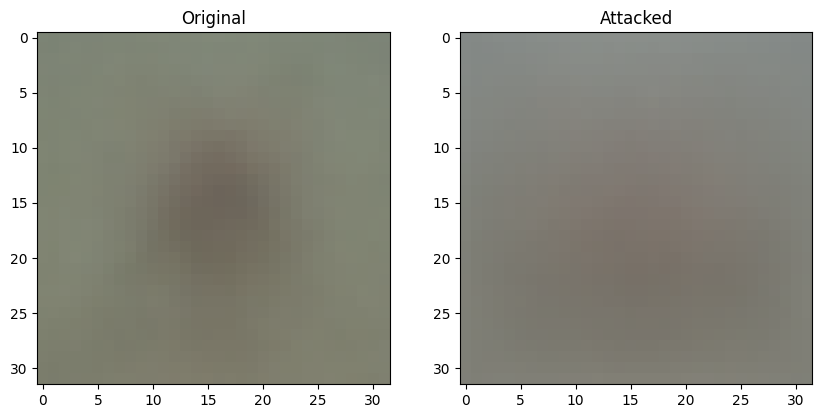

In [88]:
pred = model.predict(test_images)

#Get index of predicted = bird
bird_index = np.where(np.argmax(pred, axis=1) == 2)

#Get the images of the predicted bird
bird_images = test_images[bird_index]

pred_2 = model.predict(attacked_images)

#Get index of predicted = bird
bird_index_2 = np.where(np.argmax(pred_2, axis=1) == 2)

#Get the images of the predicted bird
bird_images_2 = attacked_images[bird_index_2]

#Get mean confidence of attacked images and original images
mean_confidence = np.mean(np.max(pred_2, axis=1))
mean_confidence_original = np.mean(np.max(pred, axis=1))

print(f"Mean confidence of attacked images: {mean_confidence}")

print(f"Mean confidence of original images: {mean_confidence_original}")

#Get avg colormap of the images
avg_colormap = np.mean(bird_images, axis=0)
avg_colormap_2 = np.mean(bird_images_2, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(10,10))
axes = axes.ravel()

#show colormaps
axes[0].imshow(avg_colormap)
axes[0].set_title("Original")

axes[1].imshow(avg_colormap_2)
axes[1].set_title("Attacked")

In [184]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

#Extract features from the images using the model

#Combine train and attacked images, split the datasets and combine them
images = np.concatenate((test_images[100:200], attacked_images[200:300]), axis=0)

#Example: If you have labels for normal and backdoor images
#For demonstration, assume we have labels (0 = normal, 1 = backdoor)
labels = [0 for i in range(100)] + [1 for i in range(100)]  # Replace with your actual labels for normal and backdoor images

features = model.predict(images)

#Flatten the features if necessary and normalize them
features = features.reshape(features.shape[0], -1)
features = StandardScaler().fit_transform(features)  # Normalize the features

#PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

#t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(features)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [ ]:
#Visualize PCA Results
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue', label='Normal Images')
plt.title('PCA Visualization of Image Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

#Visualize t-SNE Results
plt.figure(figsize=(10, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c='red', label='Normal Images')
plt.title('t-SNE Visualization of Image Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

#Visualize PCA with labels
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='coolwarm', alpha=0.6)
plt.title('PCA with Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(scatter.legend_elements(), title="Labels")
plt.show()

#Visualize t-SNE with labels
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='coolwarm', alpha=0.3)
plt.title('t-SNE with Labels')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(scatter.legend_elements(), title="Labels")
plt.show()

In [30]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load your trained model
model = models.load_model('colab_model_3.h5')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Modify the model to extract the second-to-last layer (for Grad-CAM)
model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-1].output)

def grad_cam(model, img_array, class_idx):
    # Get the correct layer name (check the actual name)
    last_conv_layer = model.get_layer('conv2d_5')  # Ensure this is correct, print model layer names to verify

    # Create a model that outputs feature maps and predictions
    grad_model = tf.keras.models.Model(inputs=[model.input], outputs=[last_conv_layer.output, model.output])

    # Record gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]  # Class prediction for the selected class

    # Ensure gradients are computed
    grads = tape.gradient(loss, conv_outputs)
    if grads is None:
        print("Gradients are None. Check the layer name and model output.")
        return None

    # Pool the gradients across all the axes (height and width)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel of the feature map with its corresponding gradient weight
    conv_outputs = conv_outputs[0]  # Remove batch dimension
    heatmap = tf.reduce_sum(tf.multiply(conv_outputs, pooled_grads), axis=-1)

    # Apply ReLU to the heatmap (only keep positive values)
    heatmap = tf.maximum(heatmap, 0)

    # Normalize the heatmap between 0 and 1
    heatmap = heatmap / tf.reduce_max(heatmap)

    return heatmap

# Function to get the class index of the predicted class
def get_class_idx(img_array):
    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions)  # Get the index of the predicted class
    return class_idx

# Function to display the Grad-CAM
def display_gradcam(img_array, class_idx):
    # Get the Grad-CAM heatmap for the predicted class
    heatmap = grad_cam(model, img_array, class_idx)
    if heatmap is None:
        return

    # Convert the heatmap to a numpy array and resize it to the original image size
    heatmap = heatmap.numpy()
    
    # Resize heatmap to the original image size (32x32)
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))  # Resize to match original image shape

    # Convert heatmap to color map (for visualization)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose the heatmap on the original image
    superimposed_img = cv2.addWeighted(img_array[0], 0.6, heatmap, 0.4, 0)  # img_array[0] to remove batch dimension

    # Plot the original image with Grad-CAM heatmap
    plt.imshow(superimposed_img)
    plt.axis('off')  # Hide axes
    plt.show()

# Main function to run Grad-CAM
def apply_gradcam_to_test_images(test_images):
    # Iterate through a subset of test images (for example, the first 10 images)
    for i in range(10):  # Adjust the range to use more images if needed
        img_array = test_images[i:i+1]  # Select a single image, shape (1, 32, 32, 3)
        
        # Get the predicted class index
        class_idx = get_class_idx(img_array)

        # Display the Grad-CAM result
        display_gradcam(img_array, class_idx)

# Assuming test_images is a numpy array with shape (num_images, 32, 32, 3)
apply_gradcam_to_test_images(test_images)

c:\Users\Abbee\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer']. Received: the structure of inputs=*
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
Gradients are None. Check the layer name and model output.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Gradients are None. Check the layer name and model output.


c:\Users\Abbee\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: [['input_layer']]. Received: the structure of inputs=*
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Gradients are None. Check the layer name and model output.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Gradients are None. Check the layer name and model output.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Gradients are None. Check the layer name and model output.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Gradients are None. Check the layer name and model output.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Gradients are None. Check the layer name and model output.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Gradients are None. Check the layer name and model output.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Gradients are None. Check the layer name and model output.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Gradients are None. Check the layer name and model output.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


c:\Users\Abbee\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer']. Received: the structure of inputs=*
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Activation shape from layer conv2d: (769, 32, 32, 32)
Activation shape from layer conv2d_1: (769, 32, 32, 32)
Activation shape from layer conv2d_2: (769, 16, 16, 64)
Activation shape from layer conv2d_3: (769, 16, 16, 64)
Activation shape from layer conv2d_4: (769, 8, 8, 128)
Activation shape from layer conv2d_5: (769, 8, 8, 128)
Attack Activation shape from layer conv2d: (769, 32, 32, 32)
Attack Activation shape from layer conv2d_1: (769, 32, 32, 32)
Attack Activation shape from layer conv2d_2: (769, 16, 16, 64)
Attack Activation shape from layer conv2d_3: (769, 16, 16, 64)
Attack Activation shape from layer conv2d_4: (769, 8, 8, 128)
Attack Activation shape from layer conv2d_5: (769, 8, 8, 128)
Difference in activations for layer conv2d: 67220.03125
Difference in activations for layer conv2d_1: 2304122.25
Difference in activations for layer conv2d_2: 3770865.75
Difference in activations for layer conv2d_3

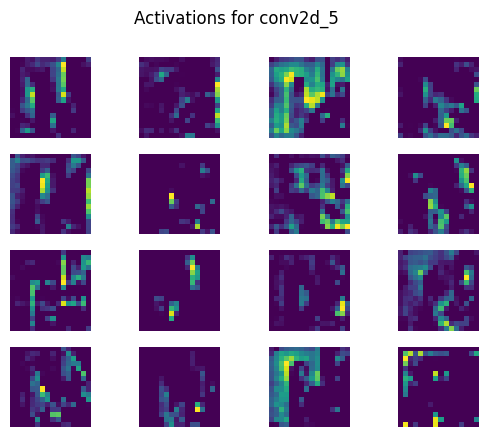

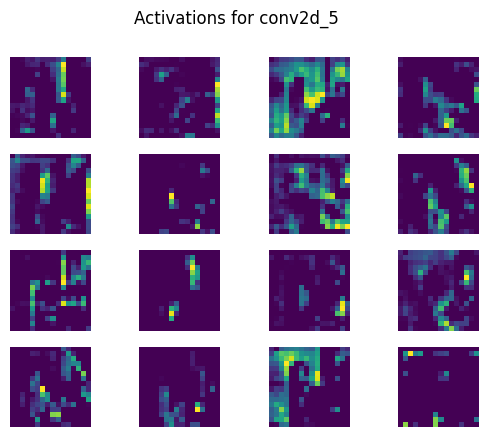

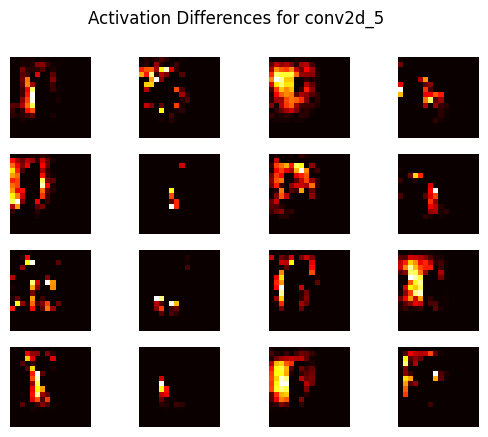

In [13]:
from tensorflow.keras import models
import numpy as np

def visualize_activation(activation, layer_name, index=0):
    num_filters = activation.shape[-1]
    size = activation.shape[1]
    for i in range(min(16, num_filters)):  # Visualize up to 16 filters
        plt.subplot(4, 4, i + 1)
        plt.imshow(activation[index, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(f"Activations for {layer_name}")
    plt.show()

def visualize_differences(original, attacked, layer_name, index=0):
    diff = np.abs(original - attacked)
    num_filters = diff.shape[-1]
    for i in range(min(16, num_filters)):  # Visualize up to 16 filters
        plt.subplot(4, 4, i + 1)
        plt.imshow(diff[index, :, :, i], cmap='hot')
        plt.axis('off')
    plt.suptitle(f"Activation Differences for {layer_name}")
    plt.show()

# Load the model
model = models.load_model('colab_model_3.h5')

# Ensure the model has been called so that the layers are initialized
dummy_input = np.zeros((1,) + model.input_shape[1:])  # Create a dummy input with the correct shape
model.predict(dummy_input)  # Perform a prediction to initialize the model

# List of layer names you want to get activations for (adjust these as needed)
layer_names = ['conv2d', 'conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_4', 'conv2d_5']

# Now create a new model to return activations for the desired layers
layer_outputs = [model.get_layer(name).output for name in layer_names]
activation_model = models.Model(inputs=model.inputs, outputs=layer_outputs)

# Choose a sample image (ensure test_images is the correct shape)
#Sample images where the model predicted bird

pred = model.predict(test_images)

#Get index of predicted = bird
bird_index = np.where(np.argmax(pred, axis=1) == 2)

#Get the images of the predicted bird
sample_image = test_images[bird_index]
sample_attack = attacked_images[bird_index]

# Get the activations for the sample image
clean_activations = activation_model.predict(sample_image)
poisoned_activations = activation_model.predict(sample_attack)

# Print the activation shapes for each layer
for layer_name, activation in zip(layer_names, clean_activations):
    print(f"Activation shape from layer {layer_name}: {activation.shape}")

# Print the activation shapes for each layer
for layer_name, activation in zip(layer_names, poisoned_activations):
    print(f"Attack Activation shape from layer {layer_name}: {activation.shape}")

for original, attacked, layer_name in zip(clean_activations, poisoned_activations, layer_names):
    difference = np.abs(original - attacked).sum()
    print(f"Difference in activations for layer {layer_name}: {difference}")

#Difference in mean activations for each layer

visualize_activation(clean_activations[2], "conv2d_5")
visualize_activation(poisoned_activations[2], "conv2d_5")

# # Example for the first convolutional layer
visualize_differences(clean_activations[2], poisoned_activations[2], "conv2d_5")


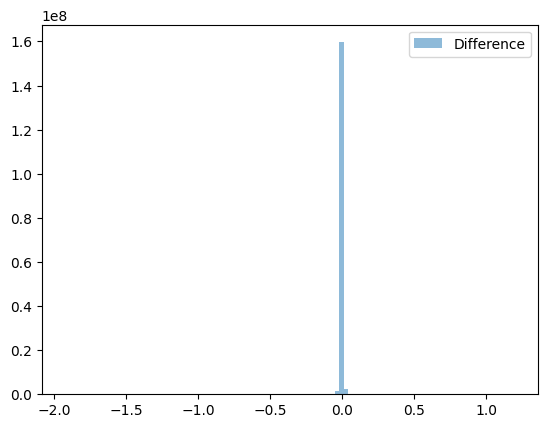

In [154]:
activation_diff = clean_activations[0] - poisoned_activations[0]
# Plot histograms of the differences
import matplotlib.pyplot as plt
plt.hist(activation_diff.flatten(), bins=100, alpha=0.5, label='Difference')
plt.legend()
plt.show()


In [14]:
clean_activations = activation_model.predict(sample_image)
poisoned_activations = activation_model.predict(sample_attack)

# Convert to NumPy arrays
clean_flattened = np.array(clean_activations[0])
poisoned_flattened = np.array(poisoned_activations[0])

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


In [148]:
import numpy as np

# Set the threshold for anomaly detection
threshold = 7

# Initialize dictionaries to store detection counts for each layer and filter
layer_poisoned_count = {}
layer_clean_count = {}

# Loop over each layer (assuming clean_activations and poisoned_activations have the same shape)
for idx, (layer_clean, layer_poisoned) in enumerate(zip(clean_flattened, poisoned_flattened)):
    # Get number of filters in this layer (last dimension is filter count)
    num_filters = layer_clean.shape[-1]

    # Initialize counters for this layer
    layer_poisoned_count[idx] = 0
    layer_clean_count[idx] = 0

    # Loop over each filter
    for f in range(num_filters):
        # Get the activation for this filter across all images
        clean_filter = layer_clean[:, :, f]
        poisoned_filter = layer_poisoned[:, :, f]
        
        # Calculate mean and standard deviation per filter for clean activations
        mean_clean = np.mean(clean_filter)
        std_clean = np.std(clean_filter)
        
        # Calculate z-scores for each poisoned activation
        z_scores_poisoned = (poisoned_filter - mean_clean) / std_clean
        
        # Check if any z-score exceeds the threshold for poisoned images
        if np.any(np.abs(z_scores_poisoned) > threshold):
            layer_poisoned_count[idx] += 1

        # Calculate z-scores for clean activations
        z_scores_clean = (clean_filter - mean_clean) / std_clean
        
        # Check if any z-score exceeds the threshold for clean images
        if np.any(np.abs(z_scores_clean) > threshold):
            layer_clean_count[idx] += 1

# Now, calculate which layer has the best poisoned vs. clean detection ratio
best_layer_idx = None
best_ratio = 0

# Calculate detection ratio per layer and find the best
for idx in layer_poisoned_count:
    # Avoid division by zero if there are no clean detections
    if layer_clean_count[idx] > 0:
        detection_ratio = layer_poisoned_count[idx] / layer_clean_count[idx]
    else:
        detection_ratio = float('inf')  # Treat as extremely high ratio

    # Update best layer if this one has a higher detection ratio
    if best_layer_idx is None or detection_ratio > best_ratio:
        best_layer_idx = idx
        best_ratio = detection_ratio

print(f"Layer {best_layer_idx} has the best poisoned vs. clean detection ratio of {best_ratio:.2f}")
print(f"Number of poisoned activations detected in this layer: {layer_poisoned_count[best_layer_idx]}")
print(f"Number of clean activations detected in this layer: {layer_clean_count[best_layer_idx]}")


C:\Users\Abbee\AppData\Local\Temp\ipykernel_21616\4107534742.py:30: RuntimeWarning: invalid value encountered in divide
  z_scores_poisoned = (poisoned_filter - mean_clean) / std_clean
C:\Users\Abbee\AppData\Local\Temp\ipykernel_21616\4107534742.py:37: RuntimeWarning: invalid value encountered in divide
  z_scores_clean = (clean_filter - mean_clean) / std_clean
C:\Users\Abbee\AppData\Local\Temp\ipykernel_21616\4107534742.py:30: RuntimeWarning: divide by zero encountered in divide
  z_scores_poisoned = (poisoned_filter - mean_clean) / std_clean


Layer 3366 has the best poisoned vs. clean detection ratio of 3.80
Number of poisoned activations detected in this layer: 19
Number of clean activations detected in this layer: 5


In [14]:


print(clean_flattened.shape[-1])
print(f"Clean activations shape: {clean_flattened.shape}")
print(f"Poisoned activations shape: {poisoned_flattened.shape}")

# Set the threshold for anomaly detection
threshold = 10
count_clean = 0
count_poisoned = 0

# Only check the last layer (i.e., the last element in the activations array)
last_layer_clean = clean_flattened[:, :, 18]  # Get the last filter from clean activations
last_layer_poisoned = poisoned_flattened[:, :, 18]  # Get the last filter from poisoned activations

# Calculate mean and standard deviation per filter for clean activations
mean_clean = np.mean(last_layer_clean)
std_clean = np.std(last_layer_clean)

# Calculate z-scores for the poisoned activations
z_scores_poisoned = (last_layer_poisoned - mean_clean) / std_clean

# Check if any z-score exceeds the threshold for poisoned activations
for z_score in z_scores_poisoned:
    if np.any(np.abs(z_score) > threshold):
        count_poisoned += 1

# Calculate z-scores for the clean activations
z_scores_clean = (last_layer_clean - mean_clean) / std_clean

# Check if any z-score exceeds the threshold for clean activations
for z_score in z_scores_clean:
    if np.any(np.abs(z_score) > threshold):
        count_clean += 1

print(f"Number of potential poisoned activations detected in clean images: {count_clean}")
print(f"Number of potential poisoned activations detected in poisoned images: {count_poisoned}")

NameError: name 'clean_flattened' is not defined

In [17]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # Progress bar library

# Assuming clean_activations and poisoned_activations are lists
clean_activations = np.array(clean_activations[0])  # Convert to NumPy array
poisoned_activations = np.array(poisoned_activations[0])  # Convert to NumPy array

# Combine clean and poisoned datasets
X = np.concatenate([
    clean_activations.reshape(len(clean_activations), -1),
    poisoned_activations.reshape(len(poisoned_activations), -1)
])
y = np.array([1] * len(clean_activations) + [0] * len(poisoned_activations))

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize RandomForestClassifier with warm_start=True to add trees incrementally
n_estimators = 100
clf = RandomForestClassifier(n_estimators=1, warm_start=True, random_state=42)

# Training with progress bar
for i in tqdm(range(1, n_estimators + 1), desc="Training Random Forest"):
    clf.n_estimators = i  # Increment the number of estimators
    clf.fit(X_train, y_train)

# Evaluate
accuracy = clf.score(X_test, y_test)
print(f"Detection Accuracy: {accuracy:.4f}")


Training Random Forest: 100%|██████████| 100/100 [00:16<00:00,  6.02it/s]


Detection Accuracy: 0.1234


In [36]:
#Test the random forest on the attacked_images and test_images
clean_activations = activation_model.predict(test_images[5000:])
poisoned_activations = activation_model.predict(attacked_images[5000:])

# Assuming clean_activations and poisoned_activations are lists
clean_activations = np.array(clean_activations[0])  # Convert to NumPy array
poisoned_activations = np.array(poisoned_activations[0])  # Convert to NumPy array


#count the number of 1s in 
real = clf.predict(clean_activations.reshape(len(clean_activations), -1))

fake = clf.predict(poisoned_activations.reshape(len(poisoned_activations), -1))

# Count the number of 1s in the 'real' predictions (clean activations predicted as 1)
real_correct_count = np.sum(real == 1)

# Count the number of 0s in the 'fake' predictions (poisoned activations predicted as 0)
fake_correct_count = np.sum(fake == 0)

# Total number of real and fake samples
total_real = len(real)
total_fake = len(fake)

# Print the counts and the accuracy
print(f"Real (clean) samples predicted as 1: {real_correct_count} out of {total_real}")
print(f"Fake (poisoned) samples predicted as 0: {fake_correct_count} out of {total_fake}")

# Calculate the accuracy for both categories
real_accuracy = real_correct_count / total_real * 100
fake_accuracy = fake_correct_count / total_fake * 100

print(f"Real Accuracy (clean as 1): {real_accuracy:.2f}%")
print(f"Fake Accuracy (poisoned as 0): {fake_accuracy:.2f}%")


 40/157 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step

KeyboardInterrupt: 

In [ ]:
#Load all three models
model_original = models.load_model('model_original_30.h5')


loss, acc = model_original.evaluate(test_images, test_labels)
print(f"Original model accuracy: {acc:.4f}")

loss, acc = model_colab.evaluate(test_images, test_labels)
print(f"Colab model accuracy: {acc:.4f}")

test_labels_class = np.argmax(test_labels, axis=1)

def get_metrics(model):
    prediction = np.argmax(model.predict(test_images), axis=1)
    precision = precision_score(test_labels_class, prediction, average='macro')
    recall = recall_score(test_labels_class, prediction, average='macro')
    f1 = f1_score(test_labels_class, prediction, average='macro')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

print("Original model")
get_metrics(model_original)

print("Colab model")
get_metrics(model_colab)